In [8]:
from os.path import join

DATA_PATH = "./data"
LEARNING_DATA = join(DATA_PATH, "englishonset/EnglishLearningData.txt")
FEATURES = join(DATA_PATH, "englishonset/EnglishFeatures.txt")

In [12]:
from phoncon.corpus import LearningData, slice_word, randomize_word
from phoncon.features import FeatureSystem

ld = LearningData(LEARNING_DATA, prefix="# ")
fs = FeatureSystem.load(FEATURES) \
    .add_word_boundary("#", "word_boundary")

In [11]:
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.optimizers as optimizers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
FEATURE_COUNT = fs._data.shape[1]

16

In [ ]:
# TODO astype(float) 기능 구현하기

mapper = {"+": "1", "-": "-1"}
features = pd.read_table(FEATURE_FILES, sep="\t", index_col=0)
features = features.replace(mapper).astype(float).transpose()

# add segment feature
seg_row = pd.Series([1] * len(features.columns), index=features.columns, name="seg")
features = pd.concat([seg_row.to_frame().T, features])

boundary = pd.Series([0] * FEATURE_COUNT, index=features.index)
boundary["seg"] = -1

## Model Learning

In [17]:
data = ld._data
data["token"] = data["word"].str.split(" ")

token_count_dist = data["token"].map(len).value_counts()
token_dist = data.explode("token").groupby("token")["freq"].sum()

data.drop("token", inplace=True, axis=1)

token_count_dist / sum(token_count_dist)

token
3    0.490909
2    0.400000
4    0.109091
Name: count, dtype: float64

In [ ]:
random_words = []

RANDOM_WORD_COUNT = round(len(data) * 10.0)
for n in token_count_dist.sample(n=RANDOM_WORD_COUNT, weights=token_count_dist, replace=True).index:
  segments = features.columns.to_series().sample(n=n,replace=True)
  wd = " ".join(segments)
  random_words.append(wd)

random_words = pd.Series(list(set(random_words)))
random_words = random_words[~random_words.isin(data["word"])]
len(random_words), random_words.head()

(271,
 0    JH SH
 1     W HH
 3      D S
 4      V K
 6     SH L
 dtype: object)

In [ ]:
def tokenize(word: str):
    return pd.concat([boundary] + [features[ch] for ch in word.split()] + [boundary], axis=1)

In [ ]:
tokenize("S T R")

,0,S,T,R,1
seg,-1,1.0,1.0,1.0,-1
consonantal,0,1.0,1.0,-1.0,0
approximant,0,-1.0,-1.0,1.0,0
sonorant,0,-1.0,-1.0,1.0,0
continuant,0,1.0,-1.0,0.0,0
nasal,0,0.0,0.0,0.0,0
voice,0,-1.0,-1.0,0.0,0
spread,0,0.0,0.0,0.0,0
labial,0,0.0,0.0,0.0,0
coronal,0,1.0,1.0,1.0,0


In [ ]:
ood_data = pd.DataFrame({"word": random_words, "freq": [0] * len(random_words)})
# aug_data = pd.concat([data, ood_data], ignore_index=True)
aug_data = pd.read_table(path.join(DATA_PATH, "englishonset/augmented.tsv"),
                       sep='\t', names=["word", "freq"])

In [ ]:
def make_corpus(words):
  tokens = [tokenize(word).to_numpy().transpose() for word in words]
  max_length = max([len(word) for word in tokens])
  corpus = np.zeros((len(tokens), max_length, FEATURE_COUNT))
  for i, word in enumerate(tokens):
      corpus[i, :len(word)] = word
  return corpus

In [ ]:
corpus = make_corpus(aug_data["word"])
true_dist = np.array(aug_data["freq"]) / sum(aug_data["freq"])

In [ ]:
class GlobalSumPooling1D(layers.Layer):
  def call(self, inputs):
    return tf.reduce_sum(inputs, axis=1)

  def compute_output_shape(self, input_shape):
    return (input_shape[0], input_shape[2])

In [ ]:
# Constructing Model
input_layer = layers.Input(shape=corpus.shape[1:])
masked = layers.Masking(mask_value=0)(input_layer)
convs = []
pools = []

FILTER_SIZE = [1, 2]
FILTER_COUNT = [5, 5]
for size, cnt in zip(FILTER_SIZE, FILTER_COUNT):
    conv = layers.Conv1D(
        filters=cnt,
        kernel_size=size,
        activation='sigmoid',
        name=f"conv_{size}",
        kernel_regularizer=regularizers.L1(0.01),
    )(masked)
    pool = GlobalSumPooling1D()(conv)
    convs.append(conv)
    pools.append(pool)

concatenated = layers.Concatenate()(pools)
output_layer = layers.Dense(1, name="dense", use_bias=False)(concatenated)
# pred_dist = layers.Softmax(axis=0)(output_layer)

model = models.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 16)]              0         []                            
                                                                                                  
 masking (Masking)           (None, 5, 16)                0         ['input_1[0][0]']             
                                                                                                  
 conv_1 (Conv1D)             (None, 5, 5)                 85        ['masking[0][0]']             
                                                                                                  
 conv_2 (Conv1D)             (None, 4, 5)                 165       ['masking[0][0]']             
                                                                                              

In [ ]:
def kl_divergence_over_batch(y_true, y_pred):
  y_true = tf.transpose(y_true)  # no batch
  y_pred = tf.transpose(y_pred)
  real_pred = tf.nn.softmax(y_pred)
  loss = KLDivergence()(y_true, real_pred)
  return loss

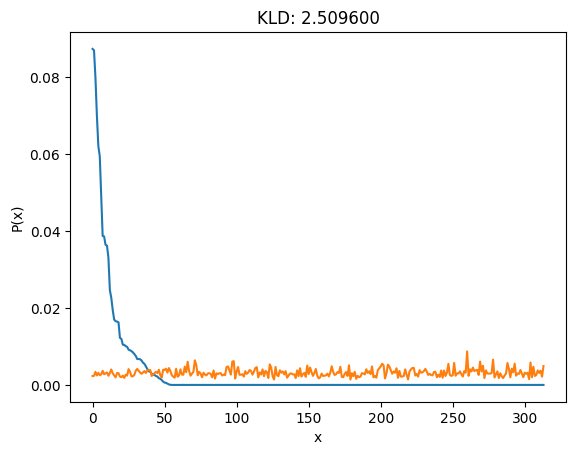

In [ ]:
def draw_plot():
  logits = model.predict(corpus, batch_size=corpus.shape[0], verbose=0)
  probs = tf.nn.softmax(tf.squeeze(logits, axis=-1))

  indice = tf.argsort(true_dist, direction='DESCENDING')

  ax = sns.lineplot(tf.gather(true_dist, indice))
  sns.lineplot(tf.gather(probs, indice))

  kl_divergence = KLDivergence()
  ax.set_title(f"KLD: {kl_divergence(true_dist, probs):.6f}")
  ax.set_xlabel('x')
  ax.set_ylabel('P(x)')

draw_plot()

In [ ]:
from tqdm.keras import TqdmCallback

adam = optimizers.Adam(learning_rate=0.02)
model.compile(loss=kl_divergence_over_batch, optimizer=adam)

early_stopping = EarlyStopping(monitor='loss', patience=100, min_delta=1e-4, mode='min')
history = model.fit(
    corpus, true_dist, epochs=10_000, batch_size=corpus.shape[0], verbose=0,
    callbacks=[
        early_stopping,
        TqdmCallback(verbose=0),
    ]
)

0epoch [00:00, ?epoch/s]

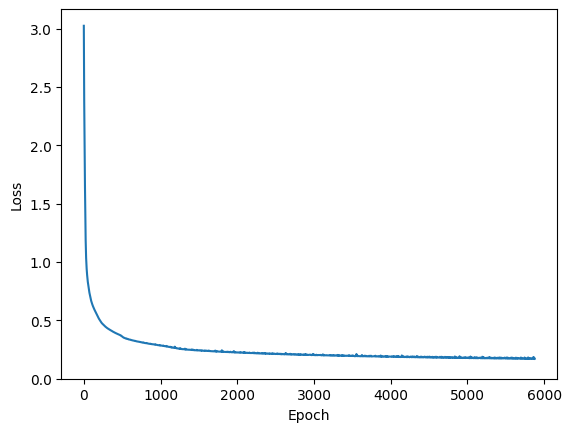

In [ ]:
ax = sns.lineplot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax.set_ylim(bottom=0)
plt.show()

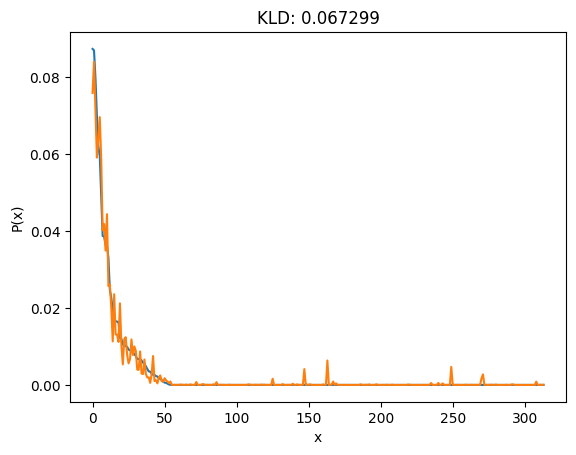

In [ ]:
draw_plot()

## Extracting Feature Weight

In [ ]:
dense = model.get_layer("dense").get_weights()
w = dense[0].reshape(-1)

<Axes: >

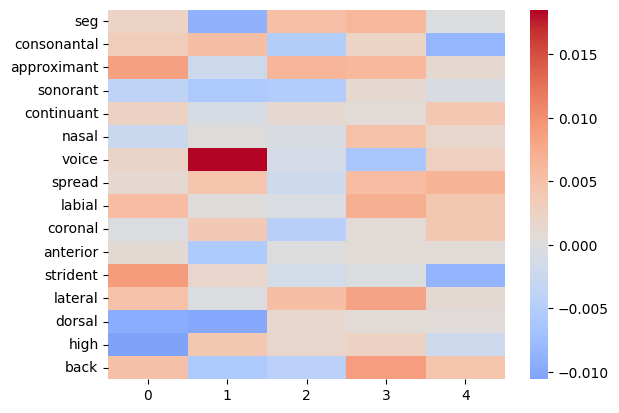

In [ ]:
conv_w = model.get_layer("conv_1").get_weights()
hm = np.transpose(conv_w[0], (1, 0, 2)).reshape(FEATURE_COUNT, -1)
hm = hm * w[:FILTER_COUNT[0]]
sns.heatmap(hm, cmap="coolwarm", center=0, yticklabels=features.index)

<Axes: >

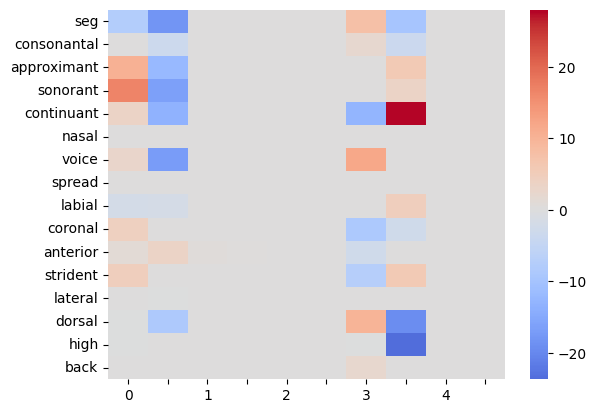

In [ ]:
conv2_w = model.get_layer("conv_2").get_weights()[0]
hm = np.transpose(conv2_w, (1, 2, 0)).reshape(FEATURE_COUNT, -1)
hm *= np.repeat(w[FILTER_COUNT[0]:], 2)
xtl = [None] * hm.shape[1]
for i in range(0, hm.shape[1], 2):
    xtl[i] = str(i // 2)

sns.heatmap(hm, cmap="coolwarm", yticklabels=features.index, xticklabels=xtl, center = 0)

In [ ]:
# Blick Test result
test_words = ["B R", "B L", "B W", "TH W", "B N", "B D", "L B"]
test_corpus = make_corpus(test_words)
y = tf.nn.softmax(np.transpose(model.predict(test_corpus, verbose=0))).numpy().squeeze(0)
pd.Series(y, index=test_words)

B R     0.664290
B L     0.214420
B W     0.093585
TH W    0.025090
B N     0.002087
B D     0.000016
L B     0.000513
dtype: float32

In [ ]:
model.predict(test_corpus, verbose=0)

array([[110.97658 ],
       [109.845795],
       [109.01673 ],
       [107.70032 ],
       [105.21338 ],
       [100.33029 ],
       [103.810455]], dtype=float32)

## Compare with H&W Learner

In [ ]:
# aug_data.to_csv(path.join(DATA_PATH, "englishonset/augmented.tsv"),
#                 index=False, header=False, sep='\t')
# ... and manually trigger ...

In [ ]:
blick = pd.read_table(
    path.join(DATA_PATH, "englishonset/output/blickTestResults.txt"),
    sep='\t', skiprows=2
)

In [ ]:
blick.head()

,word,score,3.282,5.64,5.91,5.168,5.367,4.396,6.661,4.958,...,4.82,2.692,2.967,2.06,2.057,3.051,1.845,2.096,1.703,annotation
0,K,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2764
1,R,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2752
2,D,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2526
3,S,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2215
4,M,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1965


In [ ]:
true_dist = blick['annotation'] / blick['annotation'].sum()
true_dist

0      0.087355
1      0.086976
2      0.079833
3      0.070004
4      0.062103
         ...   
309    0.000000
310    0.000000
311    0.000000
312    0.000000
313    0.000000
Name: annotation, Length: 314, dtype: float64

In [ ]:
pred_dist = np.exp(-blick['score'])
pred_dist /= pred_dist.sum()
pred_dist

0      2.177009e-02
1      2.177009e-02
2      2.177009e-02
3      2.177009e-02
4      2.177009e-02
           ...     
309    4.634293e-20
310    5.764987e-12
311    1.683092e-10
312    2.786280e-05
313    6.842943e-11
Name: score, Length: 314, dtype: float64

Text(0, 0.5, 'P(x)')

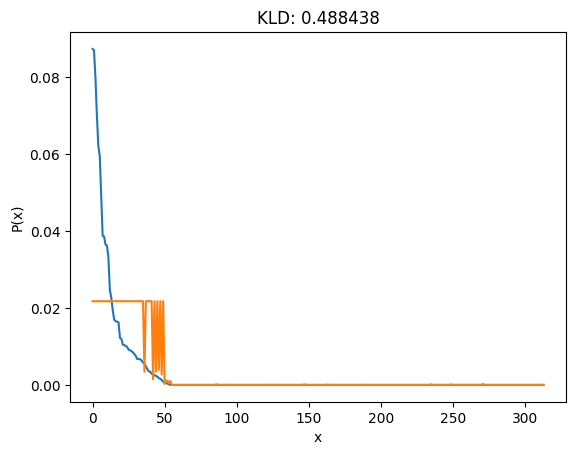

In [ ]:
indice = tf.argsort(true_dist, direction='DESCENDING')

ax = sns.lineplot(tf.gather(true_dist, indice))
sns.lineplot(tf.gather(pred_dist, indice))

kl_divergence = KLDivergence()
ax.set_title(f"KLD: {kl_divergence(true_dist, pred_dist):.6f}")
ax.set_xlabel('x')
ax.set_ylabel('P(x)')

## Model into Random Forest

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
import itertools

all_comb = list(map(' '.join, itertools.product(features.columns, repeat=2)))
X = make_corpus(all_comb)
y = model.predict(X)
y = tf.squeeze(y, 1).numpy()
y = (y - y.min()) / (y.max() - y.min())

18/18 [==============================] - 0s 2ms/step


In [ ]:
X_unfold = X[:, 1:3, :].reshape(X.shape[0], -1)
ft_names = []
for i in range(1, 2+1):
  ft_names.extend(f"{ft}[{i}]" for ft in features.index)

In [ ]:
from dataclasses import dataclass
from enum import Enum

In [ ]:
@dataclass
class FeaturePosition:
  feature: int
  position: int

  def __str__(self):
    return f"{features.index[self.feature]}[{self.position + 1}]"

  def __repr__(self):
    return str(self)


fps = [FeaturePosition(j, i) for i, j in itertools.product(range(2), range(len(features.index)))]
ft_names = [str(fp) for fp in fps]

In [ ]:
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_features=5,
    max_depth=3,
    min_samples_leaf=0.1,
    random_state=42,
    bootstrap=False,
)
rf_reg.fit(X_unfold, y)
y_pred = rf_reg.predict(X_unfold)

In [ ]:
# criterion
print(f"MSE: {mean_squared_error(y, y_pred)}")
print(f"(baseline: {mean_squared_error(y, np.random.rand(len(y)))})")

MSE: 0.02143905486476141
(baseline: 0.11773548224318903)


[Text(0.625, 0.875, 'nasal[1] <= 0.5\nsquared_error = 0.035\nsamples = 576\nvalue = 0.452'),
 Text(0.5, 0.625, 'voice[2] <= 0.5\nsquared_error = 0.036\nsamples = 504\nvalue = 0.468'),
 Text(0.25, 0.375, 'anterior[2] <= 0.5\nsquared_error = 0.037\nsamples = 336\nvalue = 0.507'),
 Text(0.125, 0.125, 'squared_error = 0.038\nsamples = 231\nvalue = 0.511'),
 Text(0.375, 0.125, 'squared_error = 0.034\nsamples = 105\nvalue = 0.497'),
 Text(0.75, 0.375, 'continuant[1] <= 0.5\nsquared_error = 0.025\nsamples = 168\nvalue = 0.392'),
 Text(0.625, 0.125, 'squared_error = 0.019\nsamples = 96\nvalue = 0.379'),
 Text(0.875, 0.125, 'squared_error = 0.033\nsamples = 72\nvalue = 0.41'),
 Text(0.75, 0.625, 'squared_error = 0.017\nsamples = 72\nvalue = 0.337')]

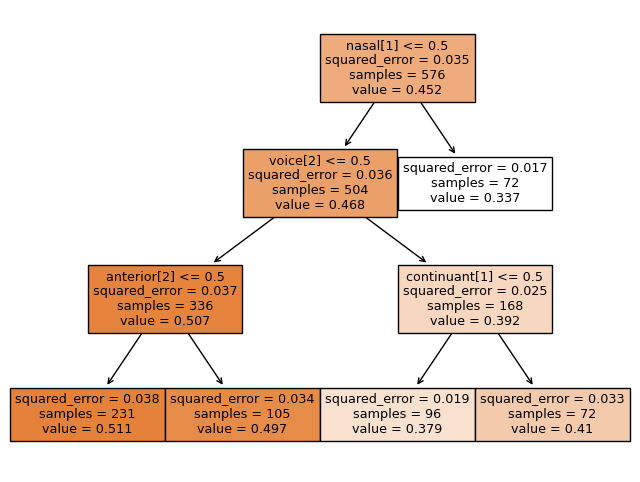

In [ ]:
plt.figure(figsize=(8, 6))
plot_tree(rf_reg.estimators_[0], feature_names=ft_names, filled=True)

In [ ]:
class Operator(Enum):
  GT = ">"
  LTE = "<="


@dataclass(frozen=True)
class Condition:
  feature: int
  threshold: float
  operator: Operator

  def __str__(self):
    return f"{ft_names[self.feature]} {self.operator.value} {self.threshold}"

  def __repr__(self):
    return f"Condition({str(self)})"

  def __hash__(self):
    return hash((self.feature, self.threshold, self.operator))

  def check(self, value):
    if self.operator == Operator.GT:
      return value > self.threshold
    else:
      return value <= self.threshold

In [ ]:
class Constraint:
  def __init__(self, conditions, score = -1):
    self.conditions = conditions
    self.window = max((fps[con.feature].position for con in self.conditions),
                      default=0)
    self.score = score

  def check(self, X):
    n = X.shape[0]
    ans = 0
    for i in range(1, n - 1 - self.window):
      if X[i + self.window, 0] != 1:  # only [+seg]
        break

      for con in self.conditions:
        fp = fps[con.feature]
        if not con.check(X[i + fp.position, fp.feature]):
          break
      else:
        ans += 1
    return ans

  def __repr__(self):
    return f"Constraint({', '.join(str(con) for con in self.conditions)}, score={self.score:.4f})"

  def __hash__(self):
    return hash(self.conditions)

  def __eq__(self, other):
    return self.conditions == other.conditions

In [ ]:
# find most inhibitted natural class
def dfs(tree, v: int = 0, conditions = []):
  if tree.children_left[v] != tree.children_right[v]:
    f = tree.feature[v]
    th = tree.threshold[v]

    l = dfs(tree, tree.children_left[v], conditions + [Condition(f, th, Operator.LTE)])
    r = dfs(tree, tree.children_right[v], conditions + [Condition(f, th, Operator.GT)])
    score = tree.value[v].item()
    return {Constraint(frozenset(conditions), score),} | l | r
  else:
    return {Constraint(frozenset(conditions), tree.value[v].item()),}


In [ ]:
constraints = set()
for tree in rf_reg.estimators_:
  constraints.update(dfs(tree.tree_))

In [ ]:
len(constraints)

979

In [ ]:
import random
from pprint import pprint

# marked_constraints = sorted(constraints, key=lambda x: x.score)[:30]
marked_constraints = random.sample(constraints, 30)
pprint(marked_constraints)

[Constraint(voice[1] > -0.5, anterior[1] > 0.5, voice[2] <= 0.5, score=0.4263),
 Constraint(sonorant[2] <= 0.0, anterior[2] > -0.5, continuant[1] <= 0.5, score=0.3935),
 Constraint(approximant[2] <= 0.0, sonorant[1] > 0.0, consonantal[1] > 0.0, score=0.3434),
 Constraint(voice[1] <= 0.0, sonorant[1] <= 0.0, continuant[2] <= 0.5, score=0.6360),
 Constraint(approximant[2] <= 0.0, nasal[1] <= 0.5, labial[2] <= 0.5, score=0.4034),
 Constraint(consonantal[2] > 0.0, anterior[2] > -0.5, strident[1] <= 0.5, score=0.4416),
 Constraint(voice[1] > -0.5, labial[1] <= 0.5, coronal[2] > 0.5, score=0.3547),
 Constraint(dorsal[2] <= 0.5, coronal[1] > 0.5, coronal[2] > 0.5, score=0.4298),
 Constraint(continuant[2] > 0.5, coronal[2] > 0.5, continuant[2] > -0.5, score=0.3869),
 Constraint(dorsal[2] <= 0.5, sonorant[2] > 0.0, score=0.6065),
 Constraint(approximant[2] <= 0.0, coronal[2] > 0.5, strident[2] > 0.0, score=0.3830),
 Constraint(voice[1] > -0.5, continuant[2] <= -0.5, voice[2] <= 0.5, score=0.304

<ipython-input-210-5a57c05059a4>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  marked_constraints = random.sample(constraints, 30)


In [ ]:
def make_tableaux(words):
  corpus = make_corpus(words)
  mat = []
  for x in corpus:
    mat.append([c.check(x) for c in marked_constraints])
  return np.array(mat)

In [ ]:
# logistic regression again
true_dist_ = aug_data["freq"] / aug_data["freq"].sum()
mat = make_tableaux(aug_data["word"])

from scipy.optimize import Bounds, minimize

beta = -5 * np.ones(mat.shape[1])
mu = np.zeros(mat.shape[1])
sig_sq = 1000 * np.ones(mat.shape[1])

def objective(beta):
  a = np.exp(mat @ beta)
  a = a / a.sum()
  return (-np.log(a) * true_dist_).sum() + (
      (0.5 * np.square(beta - mu) / sig_sq).sum()
  )

def grad(x):
  a = np.exp(mat @ x)
  a = a / a.sum()
  return (
    -(true_dist_ @ mat)
    + (a @ mat) * true_dist_.sum()
  ) + (
      (x - mu) / sig_sq
  )

res = minimize(objective, beta, method="L-BFGS-B", jac=grad)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.802343196074032
        x: [-1.871e-01 -2.680e+00 ... -1.152e+00 -4.265e-02]
      nit: 94
      jac: [ 2.479e-06  3.986e-06 ... -8.710e-07  1.060e-05]
     nfev: 111
     njev: 111
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>

In [ ]:
pd.DataFrame({
    "constraint": [str(c) for c in marked_constraints],
    "weight": res.x,
}).sort_values("weight", ascending=True)

,constraint,weight
10,"Constraint(approximant[2] <= 0.0, coronal[2] >...",-4.362386
1,"Constraint(sonorant[2] <= 0.0, anterior[2] > -...",-2.679726
22,"Constraint(coronal[2] <= 0.5, continuant[2] > ...",-2.467553
16,"Constraint(strident[2] <= 0.5, voice[1] > -0.5...",-1.984236
3,"Constraint(voice[1] <= 0.0, sonorant[1] <= 0.0...",-1.721671
5,"Constraint(consonantal[2] > 0.0, anterior[2] >...",-1.487764
8,"Constraint(continuant[2] > 0.5, coronal[2] > 0...",-1.340667
21,"Constraint(voice[1] > -0.5, continuant[2] <= -...",-1.284855
23,"Constraint(sonorant[2] <= 0.0, continuant[2] >...",-1.241073
4,"Constraint(approximant[2] <= 0.0, nasal[1] <= ...",-1.239734


In [ ]:
[aug_data["word"].iloc[x] for x in random.sample(list(np.where(mat[:, 16] > 0)[0]), 10)]

['R TH',
 'L F',
 'V R N',
 'G R',
 'D HH',
 'K N HH',
 'D V D',
 'G L',
 'W G',
 'G TH']

Text(0, 0.5, 'P(x)')

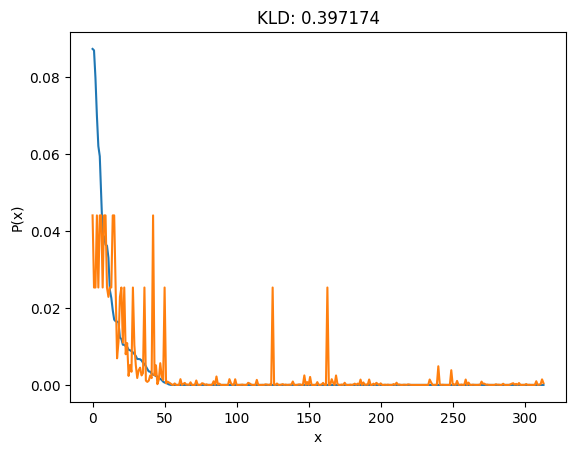

In [ ]:
a = np.exp(mat @ res.x)
a = a / a.sum()
indice = tf.argsort(true_dist_, direction='DESCENDING')

ax = sns.lineplot(tf.gather(true_dist_, indice))
sns.lineplot(tf.gather(a, indice))

kl_divergence = KLDivergence()
ax.set_title(f"KLD: {kl_divergence(true_dist_, a):.6f}")
ax.set_xlabel('x')
ax.set_ylabel('P(x)')

In [ ]:
w_logit = pd.merge(aug_data,
         pd.DataFrame({"logit": mat @ res.x}, index=aug_data.index),
         left_index=True, right_index=True)

w_logit[w_logit.freq == 0].sort_values("logit", ascending=False).head(20)

,word,freq,logit
125,ZH,0,0.000000
163,NG,0,0.000000
240,CH L,0,-1.652245
249,S R,0,-1.890239
147,P W,0,-2.327713
169,F P,0,-2.333391
86,SH L,0,-2.444317
151,TH T,0,-2.498124
166,HH N,0,-2.828421
61,P N,0,-2.828421


In [ ]:
scholes = pd.read_table(path.join(DATA_PATH, "englishonset/scholes.tsv"), header=0)
scholes

,onset,data
0,P L,28
1,T L,33
2,K L,33
3,B L,31
4,D L,26
...,...,...
61,F SH,11
62,Z V,3
63,ZH V,0
64,V Z,6


In [ ]:
print("\r\n".join([str(x) for x in make_tableaux(scholes.onset) @ res.x]))

-1.5886868303251687
-2.2989194516015177
-1.5886868303251687
-2.6427794051160576
-4.370679471162455
-3.473356173751116
-2.9584429410009263
-0.1009229072608609
-0.81115552853721
-0.1009229072608609
-1.1550154820517498
-1.7306596636321165
-0.8333363662207778
-1.4706790179366185
-4.132265150293843
-2.3807586507908116
-1.8902386775481488
-2.4443165343016293
-3.4348512255817005
-3.9619986971090855
-4.328985877727577
-1.492245342763504
-0.8929947277265039
-1.8902386775481488
-2.4443165343016293
-1.947087302517393
-2.809742812643055
-3.1767299932615463
-2.333391246032997
-0.845627322968689
-1.39970517972217
-3.692754200658725
-3.5443368381954374
-3.9113240188139287
-1.7878914247922513
-1.2973714515495887
-1.8514493083030696
-4.429761095950264
-4.956908567477649
-5.323895748096141
-3.4901733974408744
-2.0024094743765666
-2.5564873311300476
-6.217343319125062
-6.068925956661775
-6.4359131372802665
-3.815476844594716
-2.3277129215304075
-2.881790778283889
-4.871917969579945
-4.723500607116657
-5.

In [ ]:
y = model.predict(make_corpus(scholes.onset), verbose=0)
print("\r\n".join(str(x) for x in tf.squeeze(y, 1).numpy()))

110.64133
109.871315
110.36228
109.845795
109.467476
109.11109
105.079216
111.70406
110.87217
111.51199
110.97658
110.62059
110.13125
106.12941
103.84569
110.178696
109.82113
108.12666
106.87925
105.45763
103.9818
104.831635
110.76065
110.00285
108.41696
107.91968
106.14717
104.78519
107.55859
110.5113
108.117226
102.96534
105.005295
102.748085
107.81648
111.02957
108.577965
102.507576
105.00088
102.63256
107.3771
110.9279
108.3877
101.66372
104.73579
102.22411
108.33533
108.45578
106.660545
105.397835
104.49939
102.918724
106.849884
107.81991
105.814896
103.081474
103.08454
101.25542
104.892334
103.1865
105.13104
103.39439
102.486084
101.15512
103.08363
102.21745


In [ ]:
a = make_tableaux(test_words) @ res.x
a = np.exp(a)
a = a / a.sum()
print([f"{x:.4f}" for x in a])

['0.6738', '0.1522', '0.0725', '0.0543', '0.0441', '0.0026', '0.0006']


In [ ]:
1 + 2